In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import random
import pandas as pd
from glob import glob
import os


In [2]:
# !ls "results_sims/sims"

In [3]:
LR = 0.001
data_path = "results_sims_steps/sims"

In [4]:
class CombinedArrayDataset(Dataset):
    def __init__(self, folder_path):
        # Load all CSV files in the folder
        csv_files = glob(os.path.join(folder_path, "*.csv"))
        data_frames = [pd.read_csv(file) for file in csv_files]
        combined_df = pd.concat(data_frames, ignore_index=True)

        # Parse the arrays and labels
        self.belief = combined_df['belief'].apply(lambda x: np.array(eval(x), dtype=np.float32)).tolist()
        self.ship = combined_df['ship'].apply(lambda x: np.array(eval(x), dtype=np.float32)).tolist()
        self.labels = combined_df['remain'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the array and label for the given index
        belief = self.belief[idx]
        ship = self.ship[idx]
        label = self.labels[idx]

        # Convert to PyTorch tensors
        belief = torch.tensor(belief, dtype=torch.float32)  # Ensure float32 for features
        ship = torch.tensor(ship, dtype= torch.float32)
        label = torch.tensor(label, dtype=torch.float32)  # Ensure long for labels

        # Combine belief and ship as two channels
        input_tensor = torch.stack((belief, ship), dim=0)  # Shape: (2, height, width)
        return input_tensor, label

# Example usage

dataset = CombinedArrayDataset(data_path)


In [5]:
len(dataset)

122290

In [6]:
input, label = dataset[0]
input.shape, label

(torch.Size([2, 30, 30]), tensor(118.))

In [7]:
class SpaceRatNetwork1(nn.Module):
    def __init__(self,filters = 16, kernel_size = 3, strides =1 ):
        super(SpaceRatNetwork1, self).__init__()
        
        # self.conv_layer = nn.Sequential(
        #     nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2)
        # )
        self.conv1 = nn.Conv2d(2, filters, kernel_size, stride=strides, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(3600, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        # print(x.shape)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
        

In [8]:
class SpaceRatNetwork2(nn.Module):
    def __init__(self,filters = 16, kernel_size = 3, strides =1):
        super(SpaceRatNetwork2, self).__init__()
        
        self.conv1 = nn.Conv2d(2, filters, kernel_size, stride=strides, padding=1)
        
        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(filters, filters * 2, kernel_size, stride=strides, padding=1)
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(2)

        # Calculate the size after 2 Conv layers and pooling
        # After conv1: (30 - 3 + 2 * 1) / 1 + 1 = 30
        # After pool: 30 / 2 = 15
        # After conv2: (15 - 3 + 2 * 1) / 1 + 1 = 15
        # After pool: 15 / 2 = 7
        self.fc_input_size = filters * 2 * 7 * 7  # Updated input size after conv2 and pool
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(self.fc_input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x 
        

In [9]:
# class SpaceRatNetwork3(nn.Module):
#     def __init__(self):
#         super(SpaceRatNetwork3, self).__init__()
        
#         self.conv_layer = nn.Sequential(
#             nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
        
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(3600, 128)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(128, 64)
#         self.relu2 = nn.ReLU()
#         self.fc4 = nn.Linear(64, 1)
        
#     def forward(self, x):
#         x = self.conv_layer(x)
#         # print(x.shape)
#         x = self.flatten(x)
#         # print(x.shape)
#         x = self.relu1(self.fc1(x))
#         x = self.relu2(self.fc2(x))
#         x = self.fc4(x)
#         return x 
        

In [10]:
# dataset = CustomDataset(data_path)

# Train-Test Split (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
device = torch.device("mps" if torch.has_mps else "cpu")
print(f"using device: {device}")

using device: mps


/var/folders/j2/56dmz8kj7h5fyr879140wlzr0000gn/T/ipykernel_70895/1369860056.py:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if torch.has_mps else "cpu")


In [12]:
model_1 = SpaceRatNetwork1().to(device)
loss_function1 = nn.MSELoss()
optimizer1 = torch.optim.Adam(model_1.parameters(), lr=LR)

model_2 = SpaceRatNetwork2().to(device)
loss_function2 = nn.MSELoss()
optimizer2 = torch.optim.Adam(model_2.parameters(), lr=LR)

# model_3 = SpaceRatNetwork3().to(device)
# loss_function3 = nn.MSELoss()
# optimizer3 = torch.optim.Adam(model_3.parameters(), lr=LR)

In [13]:
model_1.train()
train_losses1 = []
test_losses1 = []

model_2.train()
train_losses2 = []
test_losses2 = []

# model_3.train()
# train_losses3 = []
# test_losses3 = []

In [14]:
num_epochs = 50
for epoch in range(num_epochs):
    model_1.train()
    model_2.train()
    # model_3.train()
    train_loss1 = 0.0
    train_loss2 = 0.0
    # train_loss3= 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Zero the gradients
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        # optimizer3.zero_grad()
        
        
        # Forward pass
        outputs1 = model_1(inputs)
        outputs2 = model_2(inputs)
        # outputs3 = model_3(inputs)
        
        # Compute the loss
        loss1 = loss_function1(outputs1.squeeze(), targets)
        train_loss1 += loss1.item()
        loss2 = loss_function2(outputs2.squeeze(), targets)
        train_loss2 += loss2.item()
        # loss3 = loss_function3(outputs3.squeeze(), targets)
        # train_loss3 += loss3.item()
        
        # Backward pass and optimization
        loss1.backward()
        optimizer1.step()
        loss2.backward()
        optimizer2.step()
        # loss3.backward()
        # optimizer3.step()
        
    avg_train_loss1 = train_loss1 / len(train_loader)
    train_losses1.append(avg_train_loss1)
    avg_train_loss2 = train_loss2 / len(train_loader)
    train_losses2.append(avg_train_loss2)
    # avg_train_loss3 = train_loss3 / len(train_loader)
    # train_losses3.append(avg_train_loss3)
    # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # Testing Loop
    model_1.eval()
    model_2.eval()
    # model_3.eval()
    test_loss1 = 0.0
    test_loss2 = 0.0
    # test_loss3= 0.0
    with torch.no_grad():  # No need to compute gradients during testing
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            outputs1 = model_1(inputs)
            outputs2 = model_2(inputs)
            # outputs3 = model_3(inputs)
            
            # Compute the loss
            loss1 = loss_function1(outputs1.squeeze(), targets)
            test_loss1 += loss1.item()
            loss2 = loss_function2(outputs2.squeeze(), targets)
            test_loss2 += loss2.item()
            # loss3 = loss_function3(outputs3.squeeze(), targets)
            # test_loss3 += loss3.item()

    avg_test_loss1 = test_loss1 / len(test_loader)
    test_losses1.append(avg_test_loss1)
    avg_test_loss2 = test_loss2 / len(test_loader)
    test_losses2.append(avg_test_loss2)
    # avg_test_loss3 = test_loss3 / len(test_loader)
    # test_losses3.append(avg_test_loss3)
    
    print(f"Epoch {epoch+1}/{num_epochs}| Train1:{avg_train_loss1:.4f}, Test1:{avg_test_loss1:.4f} | Train2:{avg_train_loss2:.4f}, Test2:{avg_test_loss2:.4f} ")#| Train3:{avg_train_loss3:.4f}, Test3:{avg_test_loss3:.4f}|")

Epoch 1/50| Train1:2048.4329, Test1:1716.2095 | Train2:2504.7521, Test2:1770.0409 
Epoch 2/50| Train1:1669.4224, Test1:1621.9753 | Train2:1703.8933, Test2:1706.4514 
Epoch 3/50| Train1:1603.7589, Test1:1655.2355 | Train2:1652.3331, Test2:1695.8043 
Epoch 4/50| Train1:1539.5949, Test1:1526.5052 | Train2:1581.0668, Test2:1553.5458 
Epoch 5/50| Train1:1481.5629, Test1:1444.5141 | Train2:1518.8240, Test2:1474.6522 
Epoch 6/50| Train1:1419.7729, Test1:1384.1015 | Train2:1457.4560, Test2:1429.0843 
Epoch 7/50| Train1:1368.0361, Test1:1346.9322 | Train2:1402.5984, Test2:1421.7526 
Epoch 8/50| Train1:1313.7479, Test1:1289.7262 | Train2:1339.2836, Test2:1457.0707 
Epoch 9/50| Train1:1256.0062, Test1:1250.1022 | Train2:1266.8404, Test2:1253.8823 
Epoch 10/50| Train1:1198.7551, Test1:1166.0629 | Train2:1200.7031, Test2:1163.2568 
Epoch 11/50| Train1:1144.4897, Test1:1109.4172 | Train2:1133.6670, Test2:1079.3574 
Epoch 12/50| Train1:1084.4637, Test1:1059.0864 | Train2:1073.1474, Test2:1050.2142 
E

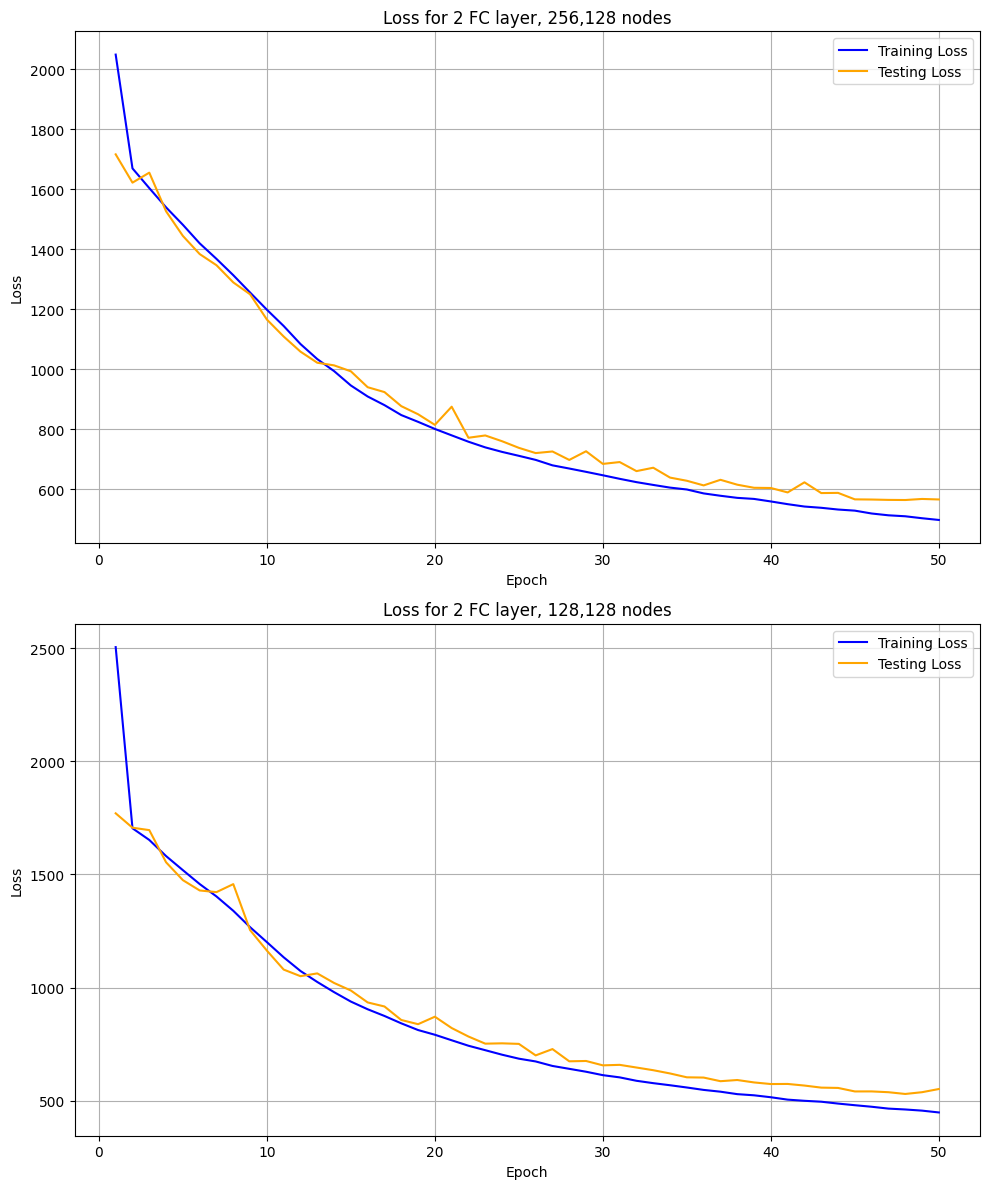

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(10, 12))  # 3 rows, 1 column

# Subplot 1: Training Loss
axes[0].plot(range(1, len(train_losses1) + 1), train_losses1, label='Training Loss', color='blue')
axes[0].plot(range(1, len(test_losses1) + 1), test_losses1, label='Testing Loss', color='orange')
axes[0].set_title('Loss for 2 FC layer, 256,128 nodes')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Subplot 2: Testing Loss
axes[1].plot(range(1, len(train_losses2) + 1), train_losses2, label='Training Loss', color='blue')
axes[1].plot(range(1, len(test_losses2) + 1), test_losses2, label='Testing Loss', color='orange')
axes[1].set_title('Loss for 2 FC layer, 128,128 nodes')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

# # Subplot 3: Training and Testing Loss
# axes[2].plot(range(1, len(train_losses3) + 1), train_losses3, label='Training Loss', color='blue')
# axes[2].plot(range(1, len(test_losses3) + 1), test_losses3, label='Testing Loss', color='orange')
# axes[2].set_title('Loss for 3 FC layer, 128,64 nodes')
# axes[2].set_xlabel('Epoch')
# axes[2].set_ylabel('Loss')
# axes[2].legend()
# axes[2].grid(True)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

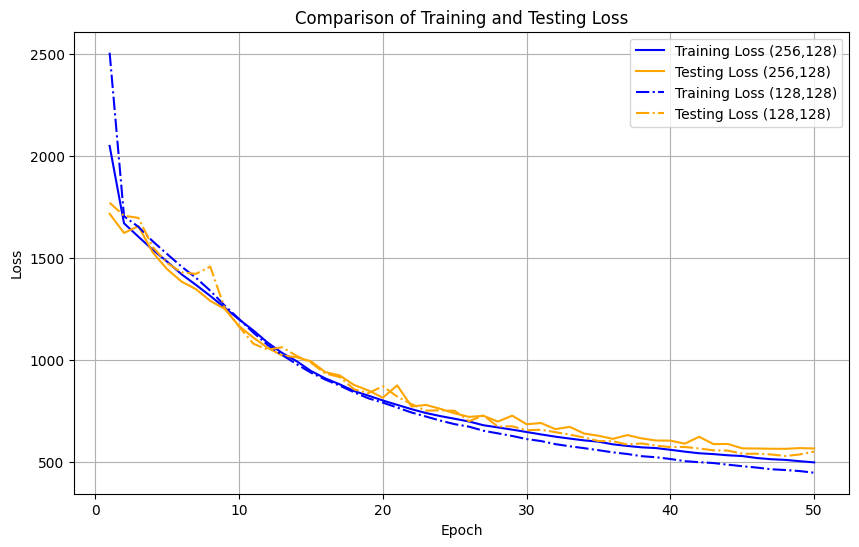

In [16]:
# Create a single plot
plt.figure(figsize=(10, 6))

# Plot Training and Testing Loss for 1 FC layer, 128 nodes
plt.plot(range(1, len(train_losses1) + 1), train_losses1, label='Training Loss (256,128)', color='blue', linestyle='-')
plt.plot(range(1, len(test_losses1) + 1), test_losses1, label='Testing Loss (256,128)', color='orange', linestyle='-')

# Plot Training and Testing Loss for 2 FC layers, 128 nodes
plt.plot(range(1, len(train_losses2) + 1), train_losses2, label='Training Loss (128,128)', color='blue', linestyle='-.')
plt.plot(range(1, len(test_losses2) + 1), test_losses2, label='Testing Loss (128,128)', color='orange', linestyle='-.')

# # Plot Training and Testing Loss for 3 FC layers, 128 nodes
# plt.plot(range(1, len(train_losses3) + 1), train_losses3, label='Training Loss (128,64)', color='blue', linestyle=':')
# plt.plot(range(1, len(test_losses3) + 1), test_losses3, label='Testing Loss (128,64)', color='orange', linestyle=':')

# Customize the plot
plt.title('Comparison of Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [17]:
# Save results to a file
results_file = "cnn count.txt"

with open(results_file, 'w') as file:
    for i in range(1,4):
        file.write(f"Layer : {i}:\n")
        file.write(f"Train Loss: {eval(f'train_losses{i}')}\n")
        file.write(f"Test Loss: {eval(f'test_losses{i}')}\n")
        file.write("-" * 50 + "\n\n")
        

NameError: name 'train_losses3' is not defined

In [17]:
# Plot the training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss: CNN(16,32), FC(256,128,64,1)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 1000x600 with 0 Axes>

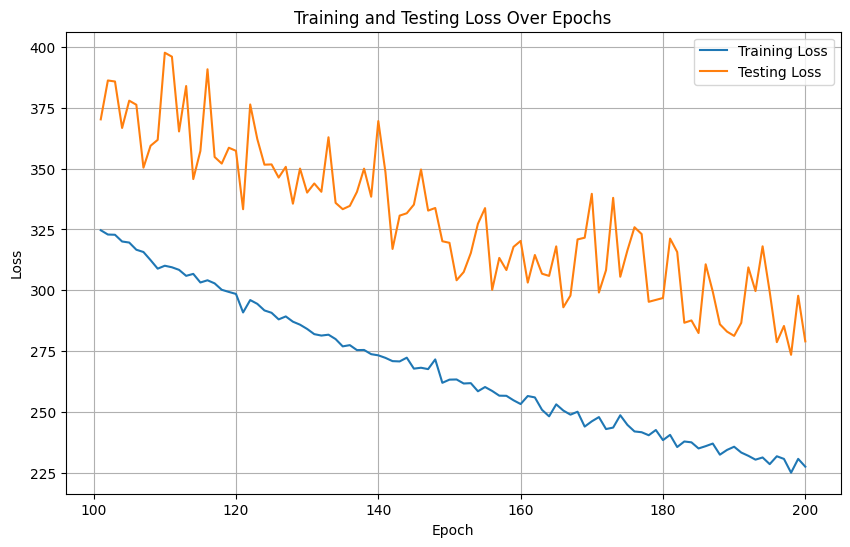

In [ ]:
# Plot the training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)+1-100, len(train_losses) + 1), train_losses[len(train_losses)-100:], label='Training Loss')
plt.plot(range(len(test_losses)+1-100, len(test_losses) + 1), test_losses[len(train_losses)-100:], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

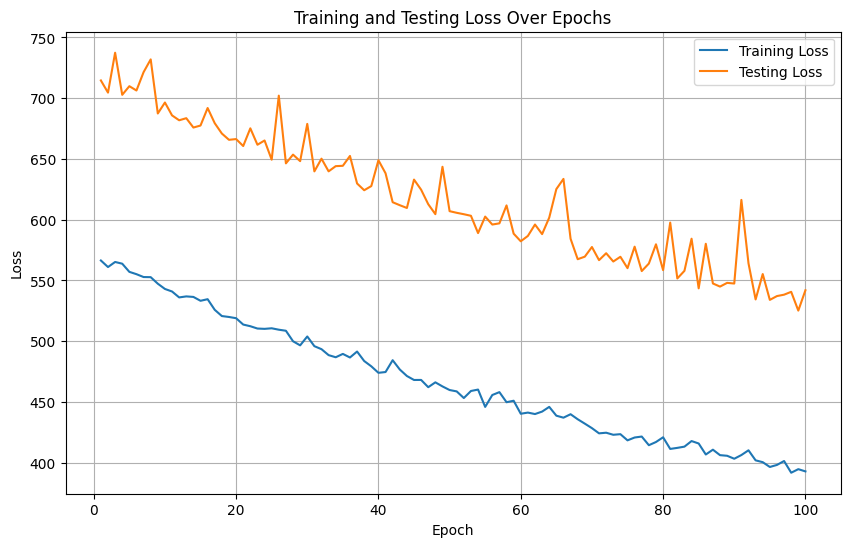

In [ ]:
# Plot the training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()